# Analyzing the Evolution of Irish Folk Traditional music

<p>Celtic music, and more specifically, Irish music has been around for at least a few hundred years now. Traditional Irish music is typically played in group settings called *seisúns*, or sessions. Being folk music, most of these tunes have been passed down the generations by ear causing many variations of the same tune to co-exist. Even today, as the tunes travel geographically, they develop slight variations acccording to the players' individual quirks. 
<p>Over recent times, websites like [thesession.org](https://thesession.org/) are beginning to collect well-known tunes in databases made up of player contributions. The website that I frequent - [thesession.org](https://thesession.org/) - features both the *abc* and *midi* formats in addition to the staff notation. Players are allowed to contribute their own versions of popular tunes which makes this site very conducive to observing patterns in the variations.  

In [1]:
# All the library imports 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import re 
import itertools 
from nltk.corpus import stopwords 

In [2]:
# All the settings  
pd.set_option('display.max_colwidth', -1) 

import warnings
warnings.filterwarnings('ignore') 

<p>Here's where I read the data that I downloaded from the API section of the website. Three files, each detailing information on the tunes, aliases and the recordings are saved into dataframes. 

In [3]:
# Get the tune, recordjing and alias data into dataframes 
tuneData = pd.read_json('.../data/tunes.json')
aliasData = pd.read_json('.../data/aliases.json')
recordData = pd.read_json('.../data/recordings.json')

In [4]:
# Saving all tunes of type 'jig' to a dataframe  
jigdf = (tuneData.loc[tuneData['type']=='jig']) 

In [5]:
jigdf.head(3)

,abc,date,meter,mode,name,setting,tune,type,username
5,|: {g}A|{Gdc}d3/2f/2{g}A{Gdc}d2f|{g}f3/2g/2a{fg}f3/2e/2d| {g}c2{GdG}e{g}A3/2{d}c/2e|{g}e3/2f/2g{afg}f3/2e/2d|\r\n{gdc}d3/2f/2{g}A{Gdc}d2f|{g}f3/2g/2a{fg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{Gdc}d3{gdc}d2:|\r\n|: {gf}g|{ag}a2f{Gdc}d2f|{g}f/2a3/2f{gfg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{g}e3/2f/2g{afg}f3/2e/2d|\r\n{ag}a2f{Gdc}d2f|{g}f/2a3/2f{gfg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{Gdc}d3{gdc}d2:|\r\n|: {g}A|{Gdc}d3{g}A3/2d/2f|{g}f/2a3/2f{gfg}f3/2e/2d|{gcd}c3{g}A3/2{d}c/2e|{g}e3/2f/2g{afg}f3/2e/2d|\r\n{gdc}d3{g}A3/2d/2f|{g}f/2a3/2f{gfg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{Gdc}d3{gdc}d2:|\r\n|:{gf}g|a2{GdG}aA3/2d/2f|{g}f/2a3/2f{gfg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{g}e3/2f/2g{afg}f3/2e/2d|\r\na2{GdG}aA3/2d/2f|{g}f/2a3/2f{gfg}f3/2e/2d|{g}c2{GdG}e{g}A3/2{d}c/2e|{Gdc}d3{gdc}d2:|,2007-04-14 22:56:09,6/8,Amixolydian,10th Bat Crossing Rhine,7078,7078,jig,gaitazampogna_32
6,d>fA d2 f | f>ga f>ed | c2 e A>ce | e>fg f>ed |\rd>fA d2 f | f>ga f>ed | c2 e A>ce | d3 d2 :|\ra2 f d2 f | f<af f>ed | c2 e A>ce | e>fg f>ed |\ra2 f d2 f | f<af f>ed | c2 e A>ce | d3 d2 :|\rd3 A>df | f<af f>ed | c3 A>ce | e>fg f>ed |\rd3 A>df | f<af f>ed | c2 e A>ce | d3 d2 :|\ra2 a A>df | f<a3f f>ed | c2 e A>ce | e>fg f>ed |\ra2 a A>df | f<a3f f>ed | c2 e A>ce | d3 d2 :|,2007-04-18 05:25:41,6/8,Amixolydian,10th Bat Crossing Rhine,18649,7078,jig,ceolachan
7,d<fA d2 A | f>ga fed | c<eA c2 e | e>fg fed |\rd<fA d2 A | f>ga fed | c>ea g>ec | d3- d2 :|\ra<Af d2 A | f<af fed | c<eA c2 e | e>fg fed |\ra<Af d2 A | f<af fed | c>ea g>ec | d3- d2 :|\rd3 A>df | f<af fed | c<eA c2 e | e>fg fed |\rd3 A>df | f<af fed | c>ea g>ec | d3- d2 :|\ra<Aa A>df | f<af fed | c<eA c2 e | e>fg fed |\ra<Aa A>df | f<af fed | c>ea g>ec | d3- d2 :|,2007-04-18 06:05:40,6/8,Dmajor,10th Bat Crossing Rhine,18650,7078,jig,ceolachan


At this point, it is obvious from the 'abc' column that the user-submitted notes are going to need a lot of processing before they can be analyzed, as they have a lot extraneous characters that we aren't interested in. A great way to extract the characters that we *are* interested in, is by using Regex, specifically the *re* package. 

In [6]:
# Define all possible notes 
notes = ['G,', 'A,', 'B,', 'C', 'D', 'E', 'F', 'G', 'A', 'B', 'c', 'd', 'e', 'f', 'g', 'a', 'b', 'c\'', 'd\''] 

In [7]:
# Create a dict of all note repetition variations for substitution later 
rep = dict();

for n in notes:
    rep[n+"2"] = n * 2
    rep[n+"3"] = n * 3
    rep[n+"4"] = n * 4
    rep[n+"5"] = n * 5
    rep[n+"6"] = n * 6

# Save all replace-able patterns into one large regex string 
# Any pattern with a match would be replaced by the corresponding value     
rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys())) 

In [9]:
# Remove all extraneous letters and characters that do not belong to the list of notes 
for index, row in jigdf.iterrows():
    row[0] = re.sub('(?:[{\"]{1,2}\w*[}\"]{1,2})', '', row[0]) 
    row[0] = re.sub('[^a-gA-G,:|\']', '', pattern.sub(lambda m: rep[re.escape(m.group(0))], row[0]))
    jigdf.set_value(index, 'abc1', row[0]) 

In [10]:
# Create a regex pattern to return all component measures in the string  
pattern1 = re.compile(r'[|:]{0,2}(?:[a-gA-G][,\'\s]{0,2}){3}(?:[a-gA-G][,\'\s]{0,2}){3}[:|]{0,2}') 

In [11]:
# Create a column to save the first 8 measures to a separate column in the jig dataset 
for index, row in jigdf.iterrows():
    basic = ''
    i = 0 
    for match in re.findall(pattern1, row[9]) :
        basic = basic + re.sub('[^a-gA-G,\']', '', match) + "|" 
        i = i + 1
        if i >= 8:
            break
    jigdf.loc[index, 'basic'] = basic 


In [14]:
# Plotting a sample jig (Morrison's) to see how the notes are laid out across versions 
sample = (jigdf.loc[jigdf['tune']==71])
keys = ['mode','tune'] 
sample2 = jigdf[jigdf.set_index(keys).index.isin(sample.set_index(keys).index)]
df_notes = sample2.basic.apply(lambda x: pd.Series(re.findall('([a-gA-G][,\']?)',x)))


<p> Now that we have the "standardized" notes, we can go ahead and substitute them with numbers to better visualize and  understand the note changes. I've picked the jig called "Morrison's Jig" and used a heatmap to help visualize how different versions might look. Note that the overarching structure of the tune is similar; it's the individual notes that vary. This makes these individual versions sound the same, yet slightly different. 

In [15]:
# This is where notes are replaced with corresponding numbers to highlight the note "level"  
num = dict();

i = 0 
for n in notes:
    num[n] = i
    i = i + 1

df_notes.replace(num, inplace=True)
df_notes_numbers = df_notes.select_dtypes(['number']) 
df_notes_clean=df_notes_numbers.apply(pd.Series.value_counts).fillna(0)
df_notes_clean = df_notes_clean.reindex(range(1, 18), fill_value=0) 


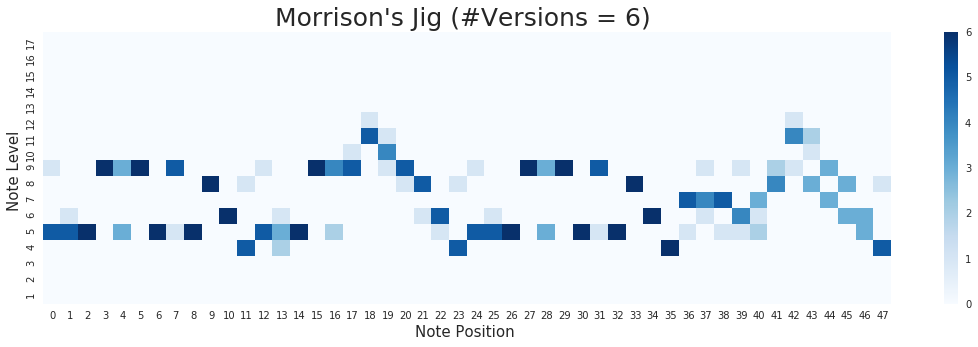

In [17]:
# And now, plot! 
sns.set(rc={"figure.figsize": (19, 5)}) 
plt.rcParams["axes.labelsize"] = 15

ax = sns.heatmap(df_notes_clean, cmap="Blues", vmin=0)  
ax.set(xlabel='Note Position ', ylabel='Note Level ') 

ax.set_title('Morrison\'s Jig (#Versions = 6) ',fontsize=25)
ax.invert_yaxis() 


In [18]:
# Similarly, replace all notes in the jigdf dataset with numbers 
df_notes = jigdf['basic'].apply(lambda x: pd.Series(list(x))) 
df_notes.replace(num, inplace=True)
df_notes_numbers = df_notes.select_dtypes(['number']) 
df_notes_clean=df_notes_numbers.apply(pd.Series.value_counts).fillna(0)

In [19]:
# This function returns the variance of notes across versions for each tune passed to it 
def getvar(df): 
#     df_notes = pd.DataFrame(re.split('([a-gA-G]{1}[,\']{0,1})', df['basic'].values[0:])).apply(lambda x: pd.Series(list(x)))
#     df_notes = df['basic'].apply(lambda x: pd.Series(re.findall('[a-gA-G][,\']{0,1}', x)))
    df_notes = df['basic'].apply(lambda x: pd.Series(re.findall('([a-gA-G][,\']?)',x)))
    df_notes.replace(num, inplace=True)
    df_notes_numbers = df_notes.select_dtypes(['number']).fillna(0) 
    df_var=df_notes_numbers.var(axis=0).to_frame().transpose() 
    return df_var

<p> **Question:** It is noticeable that the more diffused notes are towards the end of the tune. Which section of the tune has the most variance in the notes? It is possible to chart the average variance of each note across tunes to help answer that question. In the graph below, it would appear that the end of the tune is the most likely to be tinkered with. 

In [20]:
# Build a dataset of variances for each tune 
# We are interested to see how much variance can be seen for each note position across versions through the years 
tunes = jigdf.tune.unique() 
variances = pd.DataFrame() 

for t in tunes: 
    tuneset = jigdf[jigdf['tune']==t]
    df_var=getvar(tuneset) 
    variances = variances.append(df_var, ignore_index=True)

Text(0,0.5,'Average Variance')

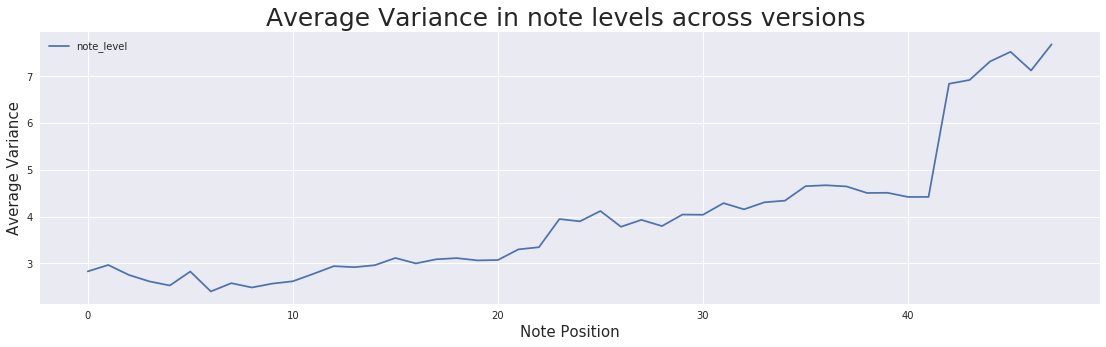

In [22]:
# Plot the average variance for each note position. Points in the tune where most tunes diverge, 
# will show the highest average variances  

plotDF = variances.mean(axis=0).to_frame() 
plotDF.columns = ['note_level']

ax = plotDF.plot()  

ax.set_title('Average Variance in note levels across versions ',fontsize=25)

# Set the x-axis label
ax.set_xlabel("Note Position")

# Set the y-axis label
ax.set_ylabel("Average Variance") 

## Typical structure of an Irish tune across the years 

<p> **Question**: What would it look like if I plotted the average of all the tunes through the years? Is there such a thing as a "typical structure" of an Irish tune? From the plot below, it would appear so. Note how the high notes are hit towards the end of the tune. And how the "average" Irish jig has maintained its structure through the years. 

In [23]:
# Plot the average note level across all irish tunes to see the typical structure of a tune 
# Where are the highs and lows? Are they consistent across the years? 

for index, row in jigdf.iterrows():
    row[0] = re.sub('(?:[{\"]{1,2}\w*[}\"]{1,2})', '', row[0]) 
    row[0] = re.sub('[^a-gA-G,:|\']', '', pattern.sub(lambda m: rep[re.escape(m.group(0))], row[0]))
    jigdf.set_value(index, 'abc1', row[0]) 
    
pattern1 = re.compile(r'[|:]{0,2}(?:[a-gA-G][,\'\s]{0,2}){3}(?:[a-gA-G][,\'\s]{0,2}){3}[:|]{0,2}') 

for index, row in jigdf.iterrows():
    basic = ''
    i = 0 
    for match in re.findall(pattern1, row[9]) :
        basic = basic + re.sub('[^a-gA-G,\']', '', match) + "|" 
        i = i + 1
        if i >= 8:
            break
    jigdf.loc[index, 'basic'] = basic 

df_basic = jigdf 
df_basic['year'] = df_basic['date'].dt.year 
df_basic_year = df_basic[['year','basic']]

df_notes = df_basic_year.join(df_basic_year['basic'].apply(lambda x: pd.Series(re.findall('([a-gA-G][,\']?)',x)))) 
df_notes.replace(num, inplace=True) 

df_notes_clean = df_notes[['year','basic']].join(df_notes.iloc[:,2:].convert_objects(convert_numeric=True).fillna(0)) 

Text(0.5,1,'Average note levels (By year) ')

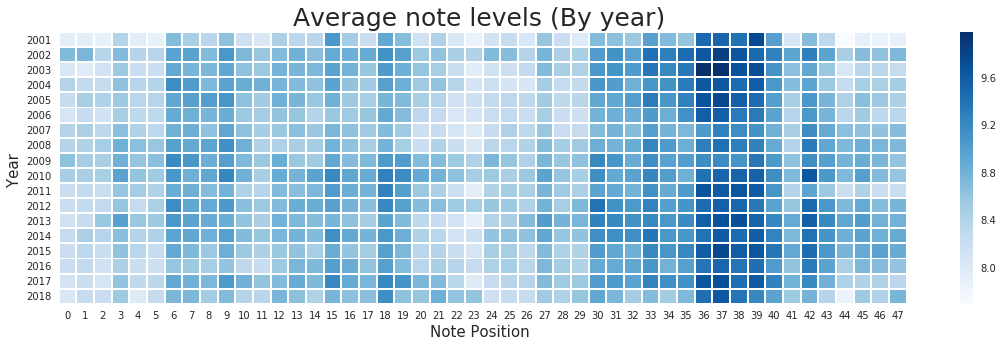

In [25]:
sns.set(rc={"figure.figsize": (19, 5)}) 

plt.rcParams["axes.labelsize"] = 15 

ax = sns.heatmap(df_notes_clean.groupby(['year']).mean(), linewidths=1, cmap="Blues")  

ax.set(xlabel='Note Position ', ylabel='Year ') 
ax.set_title('Average note levels (By year) ',fontsize=25)


## Difference in versions across years 

**Question:** How have the noted "shifted" across versions? Have they tended to rise or fall? And has that trend been maintained? 

<p> In the first graph below, from version 1 to version 2 of all tunes, note that the end sections of the tunes have majorly tended to fall in note-level, at least through the first decade. I've added the shifts between the next versions as well, in the following graphs. It's interesting to note the "pockets" of most change across the years and across tune versions. 

In [80]:
# Now that we have the note levels for all tunes, we want to see how much the notes rise or fall 
# across versions. Does that change with time? 
# Use row_of_interest to set the version from which the change needs to be computed 
def getdiff(df, row_of_interest): 
    df_notes = df['basic'].apply(lambda x: pd.Series(re.findall('([a-gA-G][,\']?)',x)))
    df_notes.replace(num, inplace=True)
    df_notes_numbers = df_notes.select_dtypes(['number']).fillna(0) 
    first_row = df_notes_numbers.iloc[[row_of_interest]].values[0]
    df_difference = df_notes_numbers.apply(lambda row: row - first_row, axis=1) 
    difference = df_difference.iloc[[row_of_interest+1]] 
    return difference

In [81]:
# Plotting average change from the first version to the second version 
tunes = jigdf.tune.unique() 
differences = pd.DataFrame() 

for t in tunes: 
    tuneset = jigdf[jigdf['tune']==t] 
    if len(tuneset.index)>1:
        df_diff=getdiff(tuneset, 0) 
        df_diff['year'] = tuneset['date'].dt.year.iloc[1]  
        differences = differences.append(df_diff, ignore_index=True) 

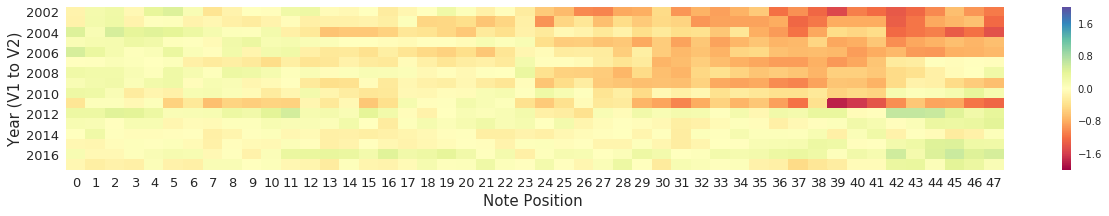

In [82]:
sns.set(rc={"figure.figsize": (21, 3)}) 
plt.rcParams["axes.labelsize"] = 15 
ax = sns.heatmap(differences[(differences.year>2001) & (differences.year<2018)].groupby(['year']).mean(), 
                 cmap="Spectral", vmin=-2, vmax=2) 
ax.set(xlabel='Note Position ', ylabel='Year (V1 to V2)') 
ax.tick_params(labelsize=13) 

In [34]:
# Get differences between versions 2 and 3 
tunes = jigdf.tune.unique() 
differences_v2 = pd.DataFrame()  

for t in tunes: 
    tuneset = jigdf[jigdf['tune']==t] 
    if len(tuneset.index)>2:
        df_diff=getdiff(tuneset, 1) 
        df_diff['year'] = tuneset['date'].dt.year.iloc[2]  
        differences_v2 = differences_v2.append(df_diff, ignore_index=True) 

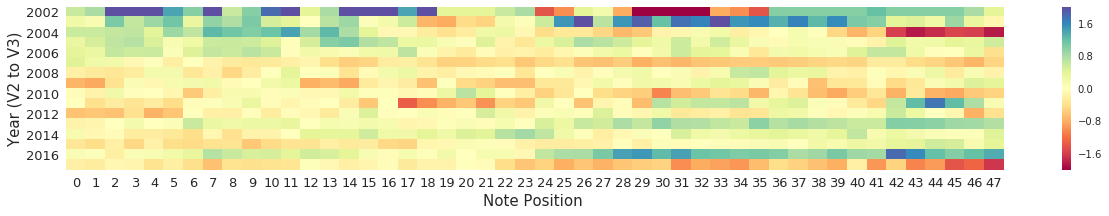

In [43]:
sns.set(rc={"figure.figsize": (21, 3)}) 
plt.rcParams["axes.labelsize"] = 15 
ax = sns.heatmap(differences_v2[(differences_v2.year>2001) & (differences_v2.year<2018)].groupby(['year']).mean(), 
                 cmap="Spectral", vmin=-2, vmax=2) 
ax.set(xlabel='Note Position ', ylabel='Year (V2 to V3)' ) 
ax.tick_params(labelsize=13)

In [46]:
# Get differences between versions 3 and 4 
tunes = jigdf.tune.unique() 
differences_v3 = pd.DataFrame()  

for t in tunes: 
    tuneset = jigdf[jigdf['tune']==t] 
    if len(tuneset.index)>3:
        df_diff=getdiff(tuneset, 2) 
        df_diff['year'] = tuneset['date'].dt.year.iloc[3]  
        differences_v3 = differences_v3.append(df_diff, ignore_index=True) 

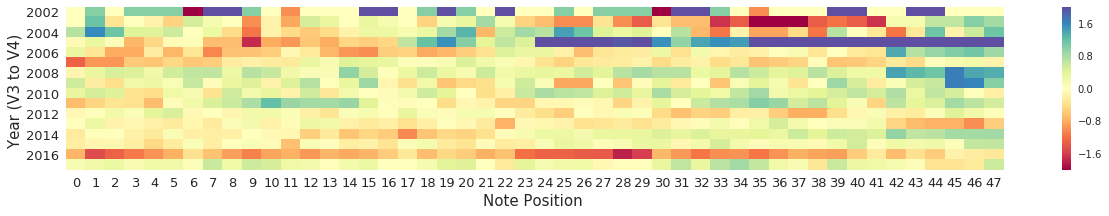

In [47]:
sns.set(rc={"figure.figsize": (21, 3)}) 
plt.rcParams["axes.labelsize"] = 15 
ax = sns.heatmap(differences_v3[(differences_v3.year>2001) & (differences_v3.year<2018)].groupby(['year']).mean(), 
                 cmap="Spectral", vmin=-2, vmax=2) 
ax.set(xlabel='Note Position ', ylabel='Year (V3 to V4) ') 
ax.tick_params(labelsize=13)

## How "Rollick-y" is a tune? 

<p> Another metric of interest to me is the number of changes in direction in a tune, somthing that lends a tune a "rollicky" sound. Has it increased or decreased over the years? We can use Regex again to find out. 

In [49]:
# This function takes a tune and returns the number of direction changes in it 
def count_direction_change(df): 
    df_notes = df['basic'].apply(lambda x: pd.Series(re.findall('([a-gA-G][,\']?)',x)))
    df_notes.replace(num, inplace=True)
    df_notes_numbers = df_notes.select_dtypes(['number']).fillna(0) 

    shift = df_notes_numbers.diff(axis=1).fillna(0) 
    direction_sign = np.sign(shift)
    df_direction = direction_sign.replace([0, -1, 1], ['S', 'D', 'U']) 
    df_direction['combined'] = df_direction[df_direction.columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
    direction_count = df_direction.combined.astype(str).str.count(r'(?=(US*D|DS*U))') 
    return direction_count 

In [51]:
# To get graph by year and version 
sample = jigdf  

tunes = jigdf.tune.unique() 
direction_changes = pd.DataFrame() 
df_dir_count = pd.DataFrame(columns=['rf', 'year', 'version']) 

# Get the number of direction changes for the first versions of all tunes 
for t in tunes: 
    tunelen = jigdf[jigdf['tune']==t] 
    if len(tunelen.index)>0: # CHange this for version number
        tuneset = jigdf[jigdf['tune']==t].iloc[[0]] # CHange this for version number   
        df_dir_count = pd.DataFrame(columns=['rf', 'year']) 
        n_directions=count_direction_change(tuneset) 
        df_dir_count['rf'] = pd.Series(n_directions)  
        df_dir_count['year'] = tuneset['date'].dt.year.iloc[0] 
        df_dir_count['version'] = 1 
        direction_changes = direction_changes.append(df_dir_count, ignore_index=True) 

# Do the same for the second and third versions of all tunes 

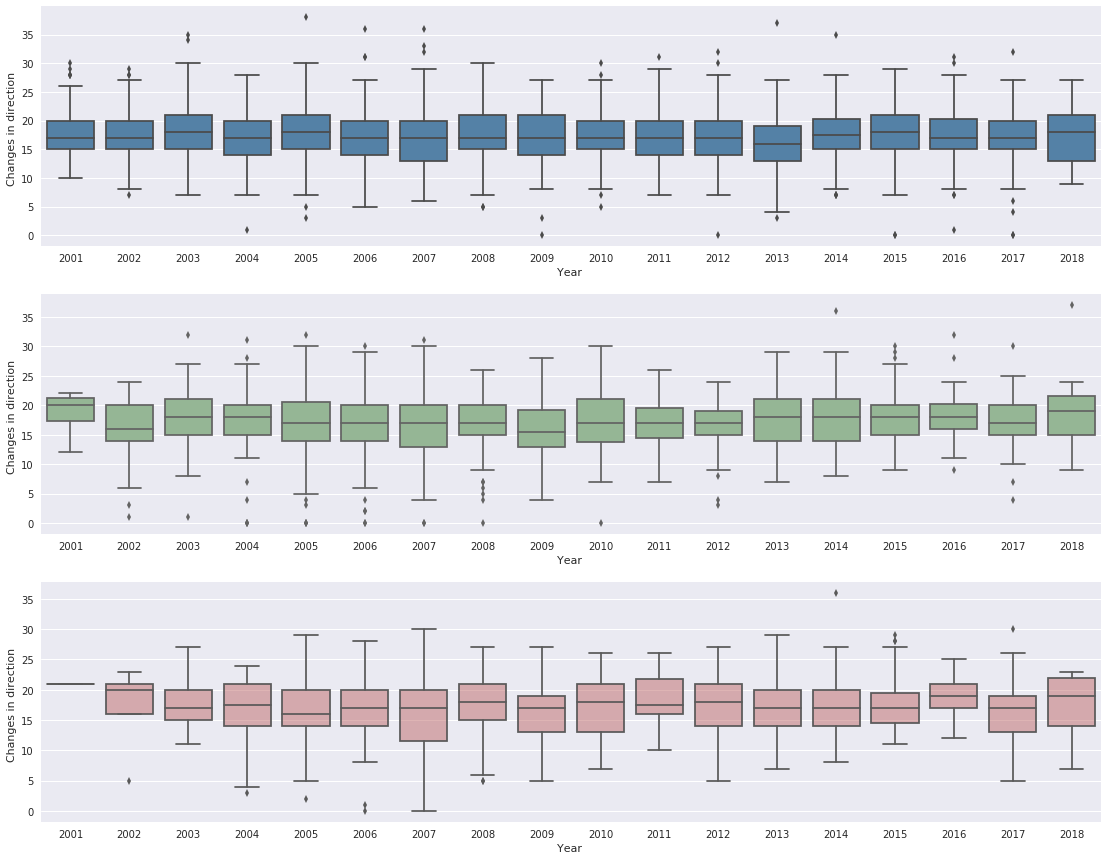

In [77]:
sns.set(rc={"figure.figsize": (19, 15)}) 

fig, axes = plt.subplots(3, 1)

ax = sns.boxplot(x="year", y="rf", data=direction_changes[direction_changes.version==1], orient='v', ax=axes[0], color="steelblue") 
ax.set(xlabel='Year ', ylabel='Changes in direction ') 
ax = sns.boxplot(x="year", y="rf", data=direction_changes[direction_changes.version==2], orient='v', ax=axes[1], color="darkseagreen") 
ax.set(xlabel='Year ', ylabel='Changes in direction ') 
ax = sns.boxplot(x="year", y="rf", data=direction_changes[direction_changes.version==3], orient='v', ax=axes[2], color="indianred") 
ax.set(xlabel='Year ', ylabel='Changes in direction ') 
# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .5))



<p> Here were all the resources I used in the making of this analysis: 
1. Tunes and Community Forum: https://thesession.org/
2. Sessions or Live Irish Trad Music: https://thesession.org/sessions 
3. API: https://thesession.org/api
4. Github data: https://github.com/adactio/TheSession-data 
5. Regex for Python: https://docs.python.org/3/library/re.html 